In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import blit_rooms
from minimal.layout import LayoutGraph, NodeType
from minimal.gen import generate_plan, PlanMasks
from minimal import sample_graphs
from minimal.rooms import RoomAreas, extract_rooms, create_orientation_mask
from minimal.walls import find_walls, intersect_rooms, join_wall_corners

%matplotlib inline

In [3]:
cmapr = ListedColormap(['white', *plt.get_cmap('tab10').colors])
cmapw = ListedColormap(['white', 'black', *plt.get_cmap('tab10').colors])

In [4]:
%%time
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_03.pth"))
rooms = extract_rooms(pm)

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.18 s


In [5]:
rect_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))

In [6]:
inner_mask, walls_mask = intersect_rooms(rooms)

tensor(True)


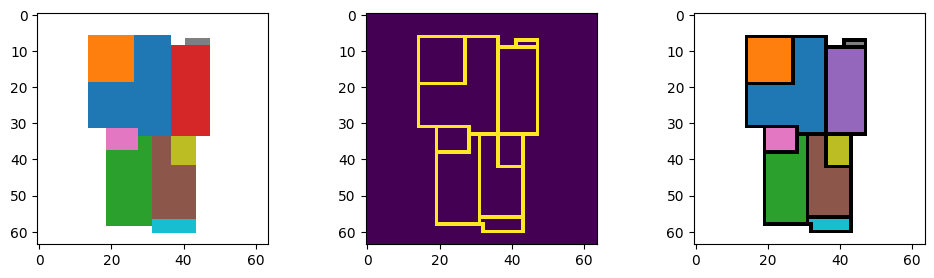

In [7]:
from minimal.walls import join_wall_corners

walls_mask = join_wall_corners(walls_mask, inner_mask)

print(torch.all(walls_mask * inner_mask == walls_mask))

plt.figure(figsize=(12,3))

plt.subplot(131)
plt.imshow(rect_mask, cmap=cmapr)

plt.subplot(132)
plt.imshow(walls_mask)

plt.subplot(133)
rooms_with_walls = sum(room.to_mask() * (i + 2) for i, room in enumerate(rooms))
rooms_with_walls[torch.where(walls_mask == 1)] = 1
plt.imshow(rooms_with_walls, cmap=cmapw)

In [8]:
BOUNDARY_TOP    = 0b0001
BOUNDARY_RIGHT  = 0b0010
BOUNDARY_BOTTOM = 0b0100
BOUNDARY_LEFT   = 0b1000

In [9]:
import torch

def zero_out_unit_length_runs(tensor: torch.Tensor) -> torch.Tensor:
    if tensor.numel() < 3:  # Edge case: A tensor of length < 3 cannot have unit-length runs
        return

    # Identify positions where a number is between two zeros
    left_shift = torch.cat([torch.tensor([0]), tensor[:-1]])  # Shift left (prepend 0)
    right_shift = torch.cat([tensor[1:], torch.tensor([0])])  # Shift right (append 0)

    # Find unit-length runs: elements that have 0 on both sides and are >0
    unit_length_mask = (left_shift == 0) & (right_shift == 0) & (tensor > 0)
    
    tensor[unit_length_mask] = 0

orient_mask = torch.zeros_like(walls_mask)

def hline(p0, p1, val):
    x0, y0 = p0
    _, y1 = p1

    line_mask = torch.zeros_like(orient_mask)
    line_mask[x0, y0:y1+1] = val
    line_mask.multiply_(walls_mask)

    zero_out_unit_length_runs(line_mask[x0, y0:y1+1])

    orient_mask.add_(line_mask)

def vline(p0, p1, val):
    x0, y0 = p0
    x1, _ = p1

    line_mask = torch.zeros_like(orient_mask)
    line_mask[x0:x1+1, y0] = val
    line_mask.multiply_(walls_mask)
    
    zero_out_unit_length_runs(line_mask[x0:x1+1, y0])
    
    orient_mask.add_(line_mask)

for room in rooms:
    for rect in room.iter_rects():
        x, y, w, h = rect

        tl = (x, y)
        tr = (x, y + w - 1)
        br = (x + h - 1, y + w - 1)
        bl = (x + h - 1, y)
    
        hline(tl, tr, BOUNDARY_TOP)
        vline(tr, br, BOUNDARY_RIGHT)
        hline(bl, br, BOUNDARY_BOTTOM)
        vline(tl, bl, BOUNDARY_LEFT)

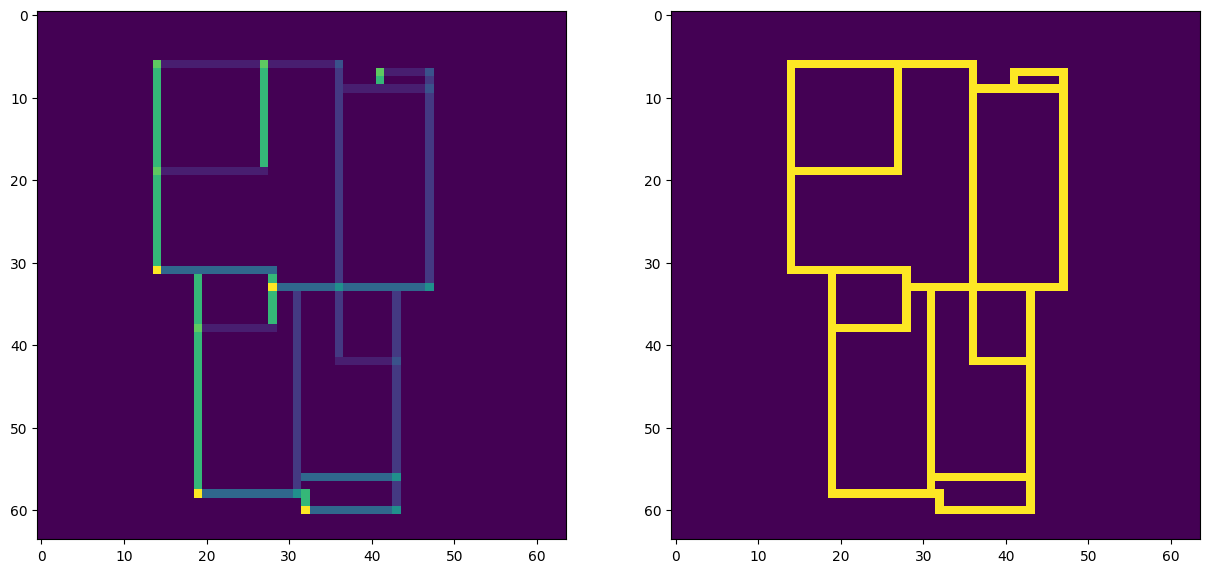

In [186]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.imshow(orient_mask)

plt.subplot(122)
plt.imshow(walls_mask)